In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

In lab 1, we have already done some EDA and pre-processing with our data so I'm not going to do it as deeply as before <br>
This time, I just keep some steps which are use to decide what columns is going to be used and what have to be changed so we can give to the model (fill nan value, check correlation, ...)

### Load data and show it

In [2]:
file_location = './nrippner-ols-regression-challenge/nrippner-ols-regression-challenge/data/cancer_reg.csv'
df = pd.read_csv(file_location)
df.head(5)

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,...,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


As we knowed from lab 1, there are only 3047 rows of data so we can't just drop 2285 rows of missing data. So I will fill it with its column mean <br>
Luckily, there is no duplicated value in the data (lab 1)

In [3]:
df["pctsomecol18_24"].fillna(df["pctsomecol18_24"].mean(), inplace = True)
df["pctemployed16_over"].fillna(df["pctemployed16_over"].mean(), inplace = True)
df["pctprivatecoveragealone"].fillna(df["pctprivatecoveragealone"].mean(), inplace = True)

### Check correlation

<AxesSubplot: >

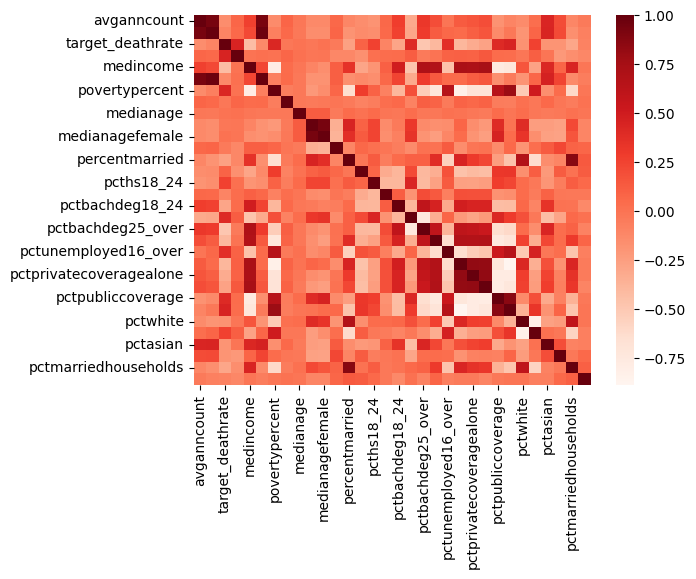

In [4]:
cor = df.corr(numeric_only=True)
sns.heatmap(cor, cmap=plt.cm.Reds, fmt='.2f')

In [5]:
strong_features = []
correlations = []
for idx, correlation in cor['target_deathrate'].items():
    if abs(correlation) >= 0.3 and idx != 'target_deathrate':
        strong_features.append(idx)
        correlations.append(correlation)
corr_price_df = pd.DataFrame({'Correlations':correlations, 
                              'Features': strong_features}).sort_values(by=['Correlations'], ascending=False)
choose = list(corr_price_df['Features'])
corr_price_df

,Correlations,Features
0,0.449432,incidencerate
10,0.449358,pctpubliccoveragealone
2,0.429389,povertypercent
3,0.404589,pcths25_over
9,0.404572,pctpubliccoverage
6,0.378412,pctunemployed16_over
8,-0.326067,pctprivatecoveragealone
7,-0.386066,pctprivatecoverage
5,-0.397487,pctemployed16_over
1,-0.428615,medincome


Here we have some features whose correlation with the target is high **(>0.3)** <br>
And I decided to give those features to our model

### Split data

In [6]:
X = df[choose]
y = df['target_deathrate']

X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

### Function to plot the result and the r-square score of model

In [7]:
def  plot_dis(y,x,model):
    yhat = model.predict(x)
    plt.figure(figsize=(10,10))
    plt.scatter(y, yhat, c='crimson')

    p1 = max(max(yhat), max(y))
    p2 = min(min(yhat), min(y))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()

In [8]:
def model_summary(model, X_train, y_train,X_test, y_test):
    print('R-square train score:', model.score(X_train, y_train))
    print('R-square test score:', model.score(X_test, y_test))
    predictions = model.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, predictions))
    print('Root mean square error:', RMSE)
    rss = pd.DataFrame({'Actual': y_test, 'Predicted':predictions})
    print('Residual sum of squares: '+ str(np.sum(np.square(rss['Predicted'] - rss['Actual']))))

## Simple Linear Regression

R-square train score: 0.47550401222085814
R-square test score: 0.5010294864755731
Root mean square error: 19.665111164421102
Residual sum of squares: 353845.68635477114


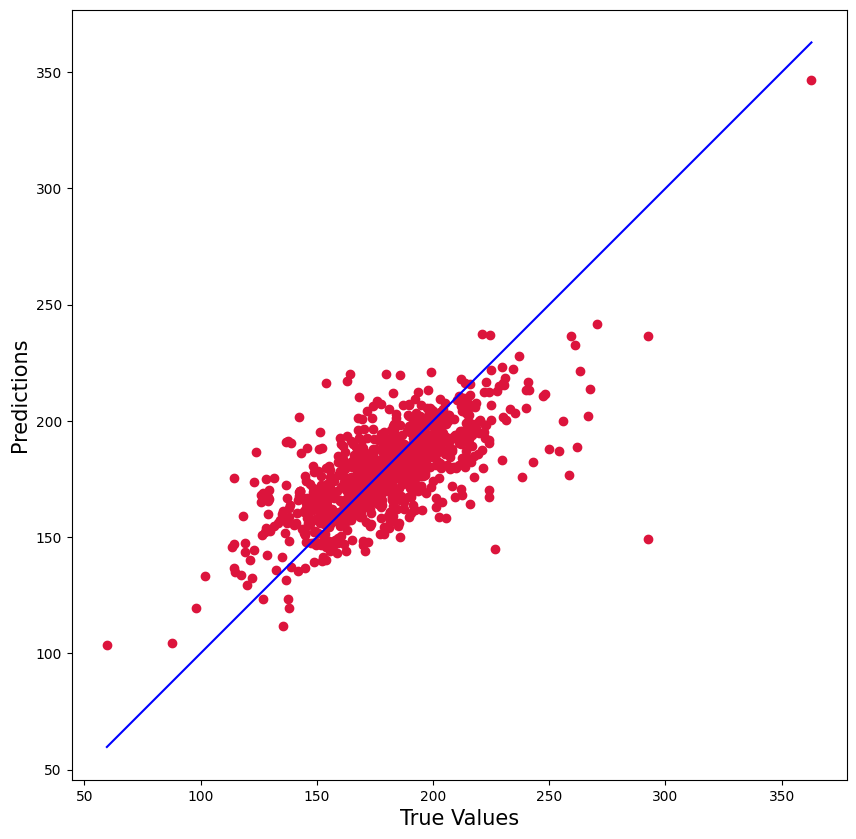

In [9]:
ss = StandardScaler()
X1 = ss.fit_transform(X_train)
X1_test = ss.fit_transform(X_test)
lr_model1 = LinearRegression()
lr_model1.fit(X1, y_train)
model_summary(lr_model1, X1, y_train, X1_test, y_test)
plot_dis(y_test, X1_test, lr_model1)

## Linear Regression with Polynomial Feature

### Degree 2

In [10]:
poly_deg2 = PolynomialFeatures(degree=2, include_bias=True)
X_train_fit2 = poly_deg2.fit_transform(X_train)
X_test_fit2 = poly_deg2.transform(X_test)

lr_poly_deg2 = LinearRegression()
lr_poly_deg2.fit(X_train_fit2, y_train)
model_summary(lr_poly_deg2, X_train_fit2, y_train, X_test_fit2, y_test)

R-square train score: 0.5506515418669018
R-square test score: 0.4599130893790402
Root mean square error: 20.459300953417067
Residual sum of squares: 383003.44088478066


I try with degree 2 first. <br>
We can see that the r-square score on the training set is improve but on the testing set is dropped. So maybe if we continue to increase the degree of PolynomialFeatures then the model will result in overfitting

### Degree 4

R-square train score: 0.7058134503081936
R-square test score: -20.31628890996284
Root mean square error: 128.53303536340349
Residual sum of squares: 15116478.179452883


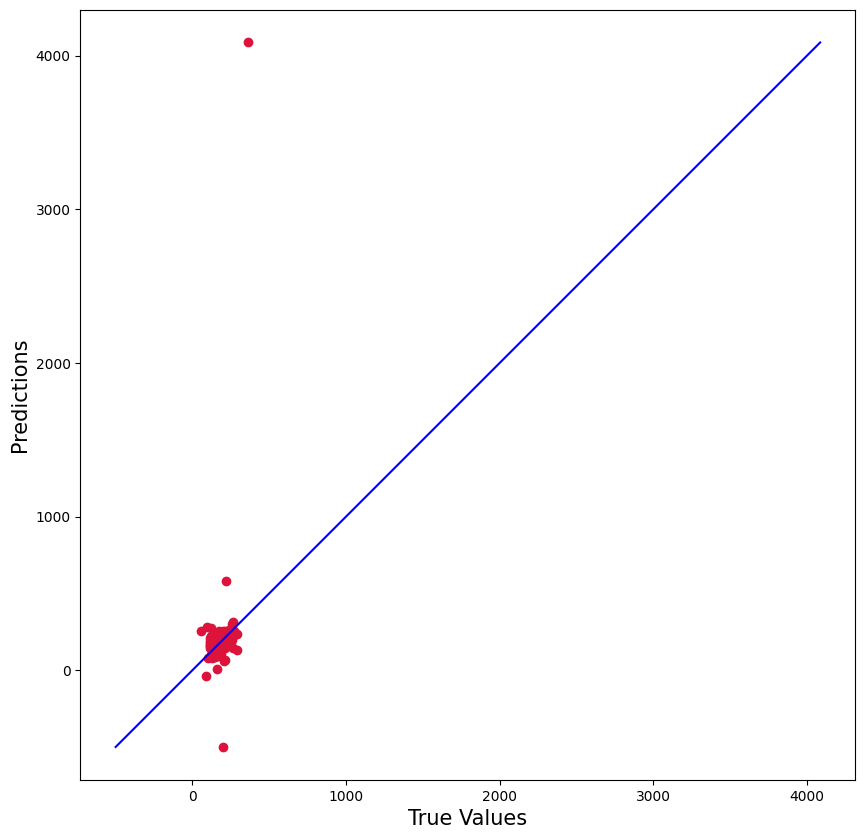

In [11]:
poly_deg3 = PolynomialFeatures(degree=4, include_bias=True)
X_train_fit3 = poly_deg3.fit_transform(X_train)
X_test_fit3 = poly_deg3.transform(X_test)

lr_poly_deg3 = LinearRegression()
lr_poly_deg3.fit(X_train_fit3, y_train)
model_summary(lr_poly_deg3, X_train_fit3, y_train, X_test_fit3, y_test)
plot_dis(y_test, X_test_fit3, lr_poly_deg3)

As expected, just by degree 4 the model will be overfitting

### Regularization (Ridge and Lasso)

In [12]:
RidgeModel = Ridge(alpha=0.01)
RidgeModel.fit(X_train, y_train)
model_summary(RidgeModel, X_train, y_train, X_test, y_test)

R-square train score: 0.47550401222085303
R-square test score: 0.503167440447743
Root mean square error: 19.62293609198165
Residual sum of squares: 352329.55309604644


In [13]:
LassoModel = Lasso(alpha=0.01)
LassoModel.fit(X_train, y_train)
model_summary(LassoModel, X_train, y_train, X_test, y_test)

R-square train score: 0.47550392994052904
R-square test score: 0.5031569371480873
Root mean square error: 19.623143510441505
Residual sum of squares: 352337.001526715


After using 4 model to perform regression in our dataset, we can see that there isn't any big differences in the score. <br>
I think is we want to improve this we can explore more deeply into the dataset to adjust the model or the feature or we can try to use cross validation and grid search to find some better model to use this specific dataset.

In [14]:
poly_deg10 = PolynomialFeatures(degree=10, include_bias=True)
X_train_fit10 = poly_deg10.fit_transform(X_train)
X_test_fit10 = poly_deg10.transform(X_test)

RidgeModel1 = Ridge(alpha=0.01)
RidgeModel1.fit(X_train_fit10, y_train)
model_summary(RidgeModel, X_train_fit10, y_train, X_test_fit10, y_test)

c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


ValueError: X has 352716 features, but Ridge is expecting 11 features as input.